# Post Data Analysis

In [2]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data
### Set start and end points
By examine output data

In [17]:
# set results path
results_file = "sample_data.csv"

startPoint = 19633 # ms
endPoint = 30146 # ms

data = pd.read_csv(results_file)
duration = data["Time (ms)"].isin(range(startPoint, endPoint))
data = data[duration]

data_np = data.to_numpy()


### A quick overview of the raw data, check if any sensors are installed in the wrong orientation
Takes a long time, uncomment and run if want to.

In [19]:
# sns.pairplot(data)
# plt.show()


## Analise Linear Encoder Results

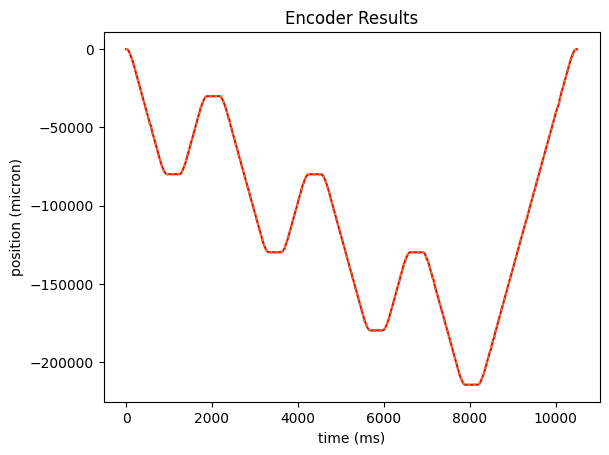

In [26]:
# set specs of encoder
resolution = 35.27777778
uncertainty = 93.4498

time = data_np[:, 0]
time = time - time[0] # in ms

position = data_np[:, 15]
position = position - position[0] # zero the measurement
# assument starting position as at 0 micron, encoder resolution is 35.27777778 microns and uncertainty (including initial position within one resolution) is +- 93.4498 microns

position = position * resolution
position_lower_bound = position - uncertainty
position_upper_bound = position + uncertainty


# plot position
plt.plot(time, position, 'r')
plt.plot(time, position_lower_bound, ':')
plt.plot(time, position_upper_bound, ':')
plt.title("Encoder Results")
plt.xlabel("time (ms)")
plt.ylabel("position (micron)")
plt.show()


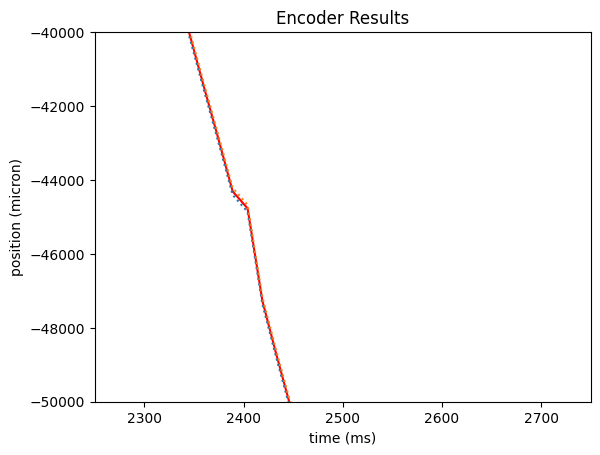

In [34]:
# plot a subsection
left = 2250
right = 2750
up = -40000
down = -50000
plt.plot(time, position, 'r')
plt.plot(time, position_lower_bound, ':')
plt.plot(time, position_upper_bound, ':')
plt.title("Encoder Results")
plt.xlabel("time (ms)")
plt.ylabel("position (micron)")
plt.xlim((left, right))
plt.ylim((down, up))
plt.show()